In [1]:
%matplotlib inline
from skimage.io import imread, imsave, imshow
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from skimage.util import random_noise
from skimage import img_as_float
from scipy.ndimage.filters import median_filter
from PIL import Image, ImageFilter, ImageChops
!pip install opencv-python
import cv2 as cv

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


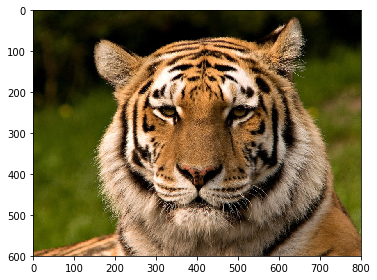

In [2]:
# Исходная картинка
img = imread('image.jpg')
imshow(img)

In [3]:
def rgb2gray(img):
    x_form = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    y_cbcr = img.dot(x_form.T)
    y_cbcr[:, :, [1, 2]] += 128

    return y_cbcr.astype('uint8')[:, :, 0]

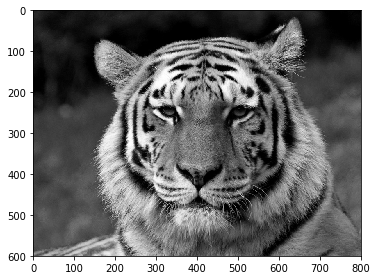

In [4]:
gray_img = rgb2gray(img)
imsave('gray_img.jpg', gray_img)
imshow(gray_img)

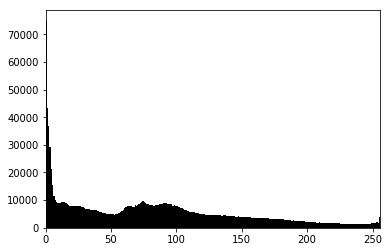

In [5]:
#2.1 Гистограмма яркостей
def create_hist(img):

    hist, bins = np.histogram(img.flatten(), 256, [0, 256])

    plt.hist(img.flatten(), 256, [0, 256], color='black')
    plt.xlim([0, 256])
    plt.show()

create_hist(img)

In [6]:
# Робастное линейное рястяжение
def brle(img, pct):
    y, x = histogram(img)
    xmin, xmax = int(np.percentile(x, pct)), int(np.percentile(x, 100 - pct))
    new_img = np.array([np.array([
            np.clip(np.uint8((px - xmin) * (255 / (xmax - xmin))), 0, 255)
            for px in row]) for row in img])
    return new_img

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


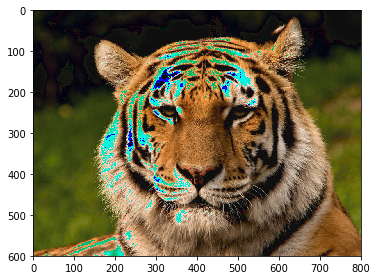

In [7]:
brle_img = brle(img, 5)
imshow(brle_img)
imsave('brle_img.jpg', brle_img)

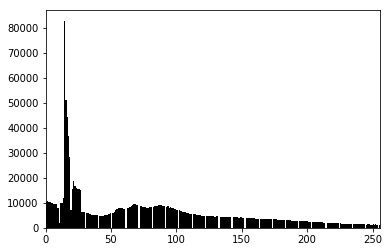

In [8]:
# Гистограмма яркостей после растяжения
create_hist(brle_img)

In [9]:
def diff_map(img1, img2, name="img1_img2"):
    _diff_map = np.abs(img1 - img2)
    imsave('diff_map_' + str(name) + '.jpg', _diff_map)
    return _diff_map

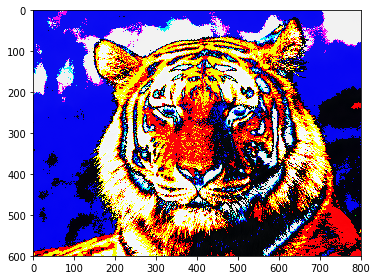

In [10]:
diff_map_brle = diff_map(img, brle_img, name="img_brle-img")
imshow(diff_map_brle)

In [11]:
def docked_map(img1, img2, name="img1_img2"):
    new_img = img1.copy()
    for px in range(len(new_img) // 2, len(new_img)):
        new_img[px] = img2[px]
    imsave('docked_map_' + str(name) + '.jpg', new_img.astype('uint8'))
    return new_img.astype('uint8')

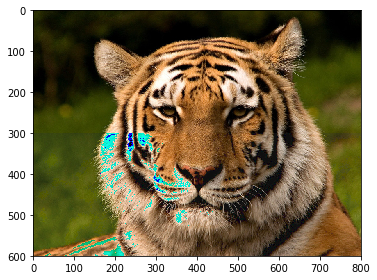

In [12]:
docked_map_brle = docked_map(img, brle_img, name="img_brle-img")
imshow(docked_map_brle)

In [13]:
# 2.2 Растяжение по каналам


def exp(img):
    y, x = histogram(img)
    xmin, xmax = int(np.percentile(x, 0)), int(np.percentile(x, 100))
    new_img = np.array([np.array([np.uint8((px - xmin) * (255 / (xmax - xmin))) for px in row]) for row in img])
    return new_img


def foreach_channel(img):
    r = exp(img[:, :, 0])
    g = exp(img[:, :, 1])
    b = exp(img[:, :, 2])
    return np.dstack((r, g, b))

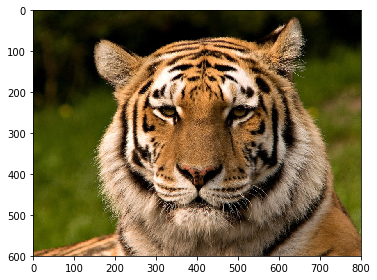

In [14]:
exp_img = foreach_channel(img)
imsave('exp_img.jpg', exp_img)
imshow(exp_img)

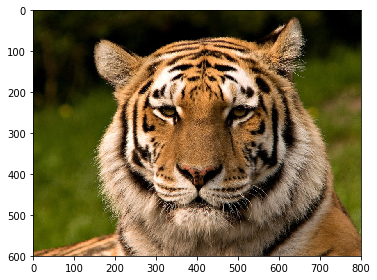

In [15]:
docked_map_exp = docked_map(img, exp_img, "img_exp-img")
imshow(docked_map_exp)

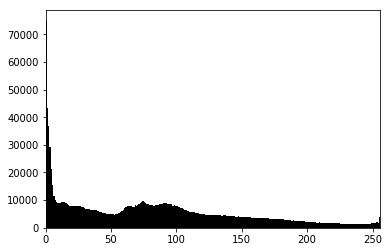

In [16]:
# Гистограмма яркостей после растяжения
create_hist(exp_img)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: diff_map_img_exp-img.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


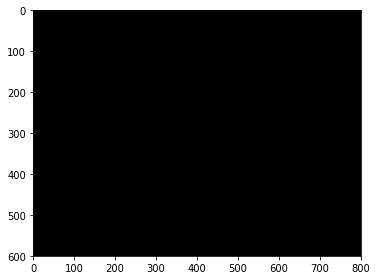

In [17]:
diff_map_exp = diff_map(img, exp_img, name="img_exp-img")
imshow(diff_map_exp)

In [18]:
def gray_world(img):
    av = np.mean(img)
    r, g, b = np.clip((av / np.mean(img[:, :, 0])) * img[:, :, 0], 0, 255), np.clip(
        (av / np.mean(img[:, :, 1])) * img[:, :, 1], 0, 255), np.clip((av / np.mean(img[:, :, 2])) * img[:, :, 2], 0,
                                                                      255)
    new_img = np.dstack((r, g, b)).astype('uint8')
    return new_img

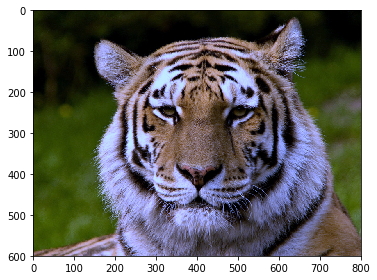

In [19]:
gw_img = gray_world(img)
imsave('gw_img.jpg', gw_img)
imshow(gw_img)

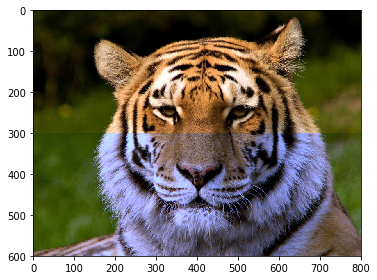

In [20]:
docked_map_gw = docked_map(img, gw_img, "img_gw-img")
imshow(docked_map_gw)

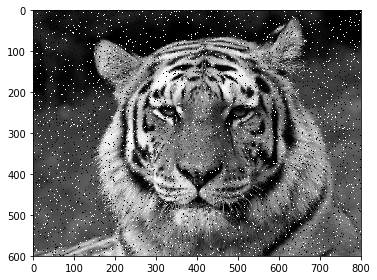

In [21]:
# 2.3

sp_gray_img = random_noise(gray_img, mode="s&p", seed=None, clip=True)
imshow(sp_gray_img)

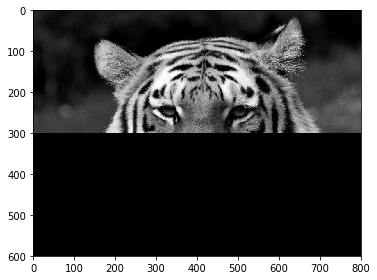

In [22]:
docked_map_sp = docked_map(gray_img, sp_gray_img, "gray-img_sp-gray-img")
imshow(docked_map_sp)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


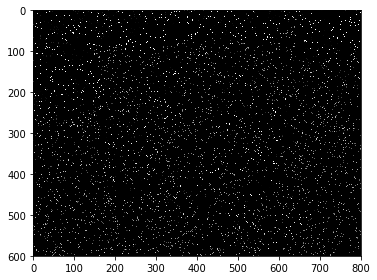

In [23]:
diff_map_sp = diff_map(img_as_float(gray_img), img_as_float(sp_gray_img), "gray-img_sp-gray-img")
imshow(diff_map_sp)

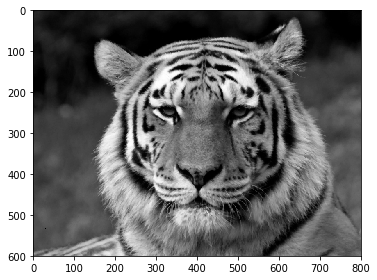

In [24]:
filtered_img = median_filter(sp_gray_img, 3)
imshow(filtered_img)

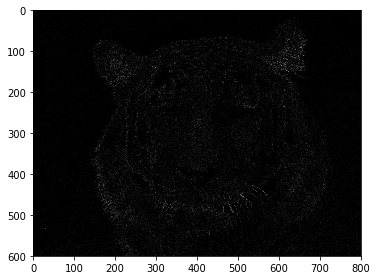

In [25]:
diff_map_filtered = diff_map(img_as_float(gray_img), img_as_float(filtered_img), "gray-img_filtered-img")
imshow(diff_map_filtered)

In [26]:
# 2.4
def convolution(img, kernel):
    
    kernel = np.flipud(np.fliplr(kernel))    
    output = np.zeros_like(img)            
    
    img_padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2))   
    img_padded[1 : -1, 1 : -1] = img
    for x in range(img.shape[1]):     
        for y in range(img.shape[0]):
            
            output[y, x]=(kernel * img_padded[y : y + 3, x : x + 3]).sum()        
    
    return output

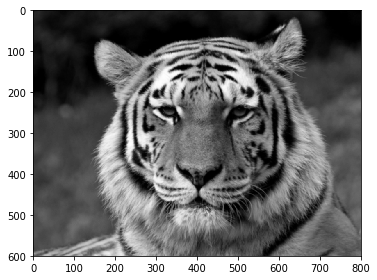

In [27]:
# Усреднение
kernel = np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]])
av_img = convolution(gray_img, kernel)
imshow(av_img)

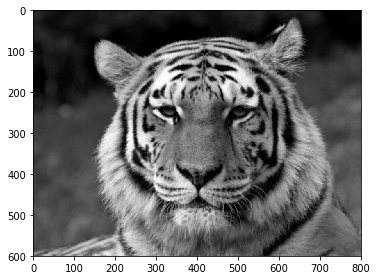

In [28]:
# Автоусреднение
pilgray = Image.open('gray_img.jpg')
autoav = pilgray.filter(ImageFilter.SMOOTH) 
autoav.save('autoav.jpg')
autoav_img = imread('autoav.jpg')
imshow(autoav_img)

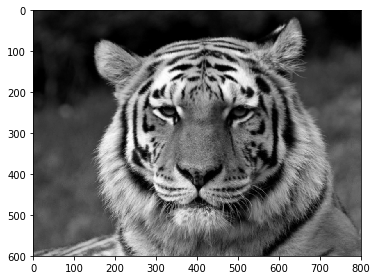

In [29]:
docked_map_av = docked_map(av_img, autoav_img, "av-img_autoav-img")
imshow(docked_map_av)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: diff_map_av-img_autoav-img.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


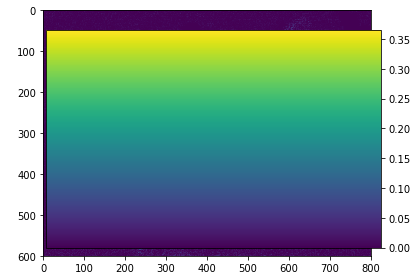

In [30]:
diff_map_av = diff_map(img_as_float(av_img), img_as_float(autoav_img), "av-img_autoav-img")
imshow(diff_map_av)

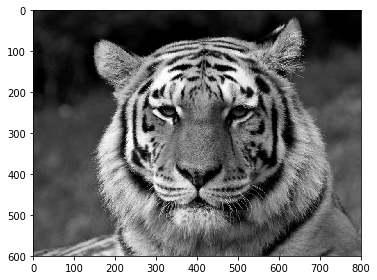

In [31]:
# Сдвиг на 1
kernel = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
shift_1 = convolution(gray_img, kernel)
imshow(shift_1)

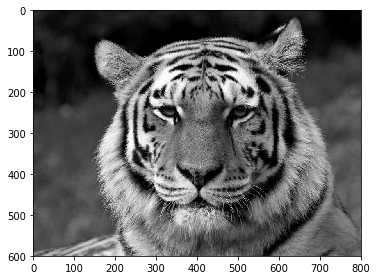

In [32]:
# Автосдвиг
pilgray = Image.open('gray_img.jpg')
autoshift = ImageChops.offset(pilgray, 1,0)
autoshift.save('autoshift.jpg')
autoshift = imread('autoshift.jpg')
imshow(autoshift)

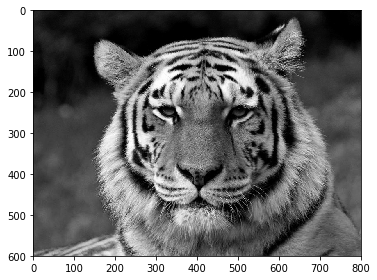

In [33]:
docked_map_shift = docked_map(shift_1, autoshift, "shift_autoshift")
imshow(docked_map_shift)

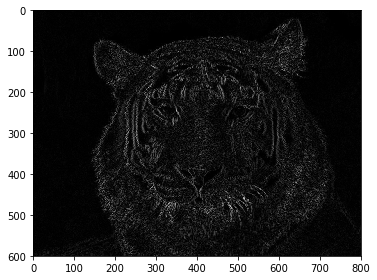

In [34]:
diff_map_shift = diff_map(img_as_float(shift_1), img_as_float(autoshift), "shift_autoshift")
imshow(diff_map_shift)

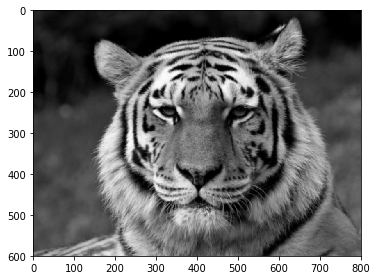

In [35]:
# Гауссов фильтр
kernel = np.array([[0.09, 0.12, 0.09],[0.12, 0.15, 0.12],[0.09, 0.12, 0.09]])
gauss = convolution(gray_img, kernel)
imshow(gauss)

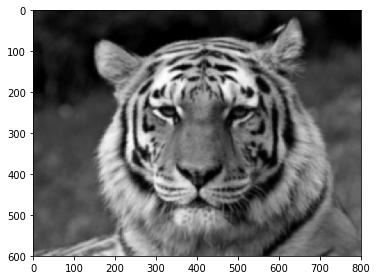

In [36]:
# Автогаусс
pilgray = Image.open('gray_img.jpg')
autogauss = pilgray.filter(ImageFilter.GaussianBlur) 
autogauss.save('autogauss.jpg')
autogauss = imread('autogauss.jpg')
imshow(autogauss)

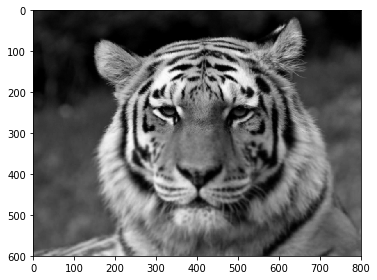

In [37]:
docked_map_gauss = docked_map(gauss, autogauss, "gauss_autogauss")
imshow(docked_map_gauss)

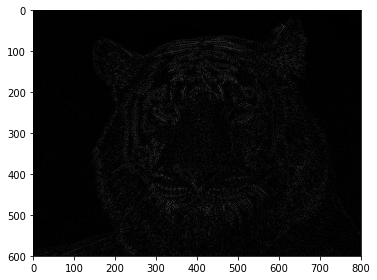

In [38]:
diff_map_gauss = diff_map(img_as_float(gauss), img_as_float(autogauss), "gauss_autogauss")
imshow(diff_map_gauss)

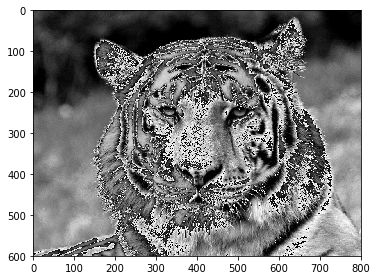

In [39]:
# Повышение резкости
kernel = np.array([[0, -0.04, 0], [-0.04, 2, -0.04], [0, -0.04, 0]])
sharp = convolution(gray_img, kernel)
imshow(sharp)

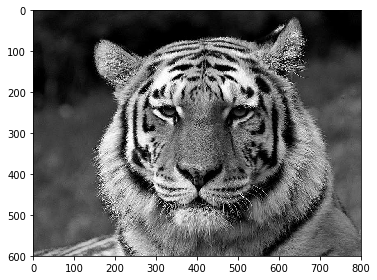

In [40]:
# Авторезкость
pilgray = Image.open('gray_img.jpg')
autosharp = pilgray.filter(ImageFilter.SHARPEN) 
autosharp.save('autosharp.jpg')
autosharp = imread('autosharp.jpg')
imshow(autosharp)

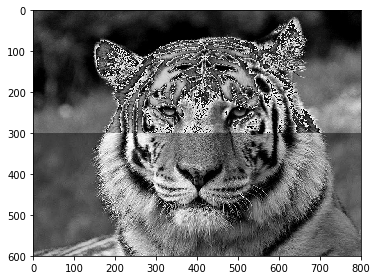

In [41]:
docked_map_sharp = docked_map(sharp, autosharp, "sharp_autosharp")
imshow(docked_map_sharp)

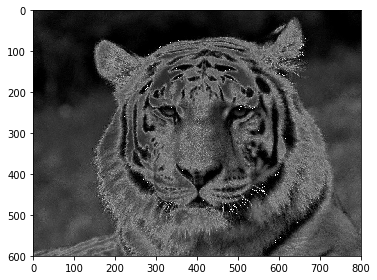

In [42]:
diff_map_sharp = diff_map(img_as_float(sharp), img_as_float(autosharp), "sharp_autosharp")
imshow(diff_map_sharp)

In [43]:
#2.5 Unsharp mask
gaussian_3 = cv.GaussianBlur(gray_img, (9, 9), 10.0)
unsharp_img = cv.addWeighted(gray_img, 1.5, gaussian_3, -0.5, 0, gray_img)
cv.imwrite('unsharp_img.jpg', unsharp_img)

True

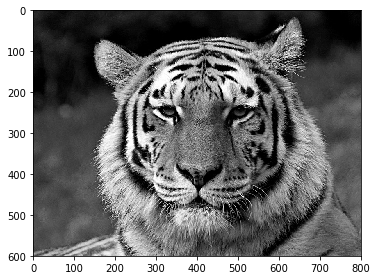

In [44]:
unsharp_img = imread('unsharp_img.jpg')
imshow(unsharp_img)

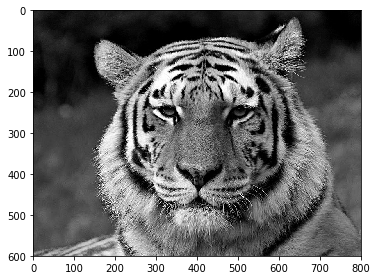

In [45]:
docked_map_unsharp = docked_map(unsharp_img, autosharp, "unsharp_autosharp")
imshow(docked_map_unsharp)

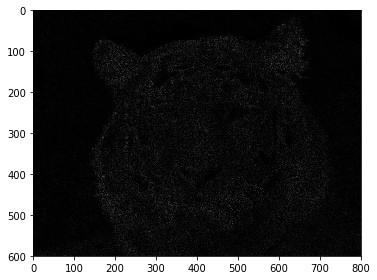

In [46]:
diff_map_unsharp = diff_map(img_as_float(unsharp_img), img_as_float(autosharp), "unsharp_autosharp")
imshow(diff_map_unsharp)